![](https://i.postimg.cc/4N0Z9wWj/Screenshot-2025-07-01-092633.png)

In [17]:
#!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0 --quiet

# 📦 Library Imports and Setup

In [18]:
# 📦 Data Handling & Visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ⚙️ Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 📊 Model Selection & Evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

# 🤖 Classifiers (Only those used so far)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# 🚫 Suppress Warnings
import warnings
warnings.filterwarnings("ignore")


In [19]:
#  Load Data
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")

In [20]:
train.head(5)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


# 🔁 Binary Feature Encoding

In [22]:
#  Encode Binary Features
binary_map = {'Yes': 1, 'No': 0}
for col in ['Stage_fear', 'Drained_after_socializing']:
    train[col] = train[col].map(binary_map)
    test[col] = test[col].map(binary_map)

# 🧠 Feature Engineering

In [23]:
#  Feature Engineering
train['Alone_per_Social'] = train['Time_spent_Alone'] / (train['Social_event_attendance'] + 1)
test['Alone_per_Social'] = test['Time_spent_Alone'] / (test['Social_event_attendance'] + 1)

train['Social_Activity_Index'] = train[['Social_event_attendance', 'Going_outside', 'Friends_circle_size']].mean(axis=1)
test['Social_Activity_Index'] = test[['Social_event_attendance', 'Going_outside', 'Friends_circle_size']].mean(axis=1)

train['Stage_fear_AND_Drained'] = train['Stage_fear'] * train['Drained_after_socializing']
test['Stage_fear_AND_Drained'] = test['Stage_fear'] * test['Drained_after_socializing']

# 🩹 Missing Value Imputation

In [24]:
train.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
Alone_per_Social             2329
Social_Activity_Index           3
Stage_fear_AND_Drained       3003
dtype: int64

In [25]:
test.isnull().sum()

id                              0
Time_spent_Alone              425
Stage_fear                    598
Social_event_attendance       397
Going_outside                 466
Drained_after_socializing     432
Friends_circle_size           350
Post_frequency                408
Alone_per_Social              812
Social_Activity_Index           0
Stage_fear_AND_Drained       1013
dtype: int64

In [26]:
#  Fill Missing Values
features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
            'Friends_circle_size', 'Post_frequency', 'Stage_fear',
            'Drained_after_socializing', 'Alone_per_Social',
            'Social_Activity_Index', 'Stage_fear_AND_Drained']

In [27]:
for col in features:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

# Checking For Data Imbalance

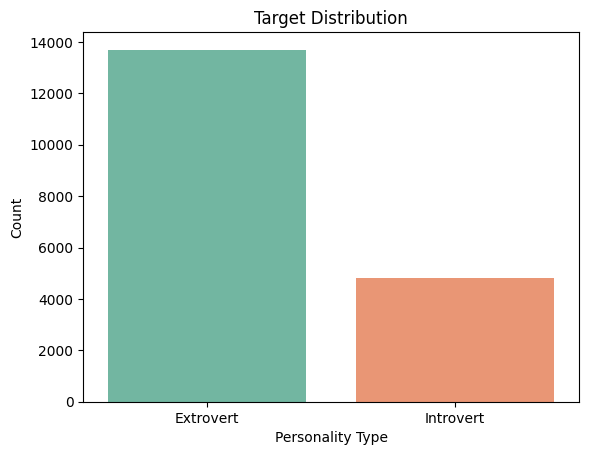

In [28]:
sns.countplot(x='Personality', data=train.replace({0: 'Introvert', 1: 'Extrovert'}), palette="Set2")
plt.title("Target Distribution")
plt.xlabel("Personality Type")
plt.ylabel("Count")
plt.show()

# 🏷️ Target Encoding

In [29]:
# Encode Target
le = LabelEncoder()
y = le.fit_transform(train['Personality']) # 0=Extrovert, 1=Introvert

# 📏 Feature Scaling

In [30]:
# Scale Features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(train[features]), columns=features)
X_test = pd.DataFrame(scaler.transform(test[features]), columns=features)


# 🏷️ Model Building

## Voting Classifier Is All You Need

![](https://i.postimg.cc/YqTK909H/1-Eek-Xro-Xi99-N05jcskd-Ps-Ig.png)

In [31]:
# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [32]:
#  Define Base Models
models = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('nb', GaussianNB()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42))
]


In [33]:
# Evaluate each model individually
print("🔍 Individual Model Accuracies (CV):")
for name, model in models:
    score = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f"{name.upper():<5}: {score.mean():.5f} (+/- {score.std():.5f})")


🔍 Individual Model Accuracies (CV):
LR   : 0.96745 (+/- 0.00193)
RF   : 0.96626 (+/- 0.00188)
GB   : 0.96847 (+/- 0.00225)
NB   : 0.96864 (+/- 0.00223)
XGB  : 0.96783 (+/- 0.00171)


In [34]:
#  Voting Classifier
voting_clf = VotingClassifier(estimators=models, voting='soft')
scores = cross_val_score(voting_clf, X, y, cv=skf, scoring='accuracy')
print(f"\n✅ Voting Classifier CV Accuracy: {scores.mean():.5f} (+/- {scores.std():.5f})")



✅ Voting Classifier CV Accuracy: 0.96896 (+/- 0.00187)


<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Smash That Upvote !! Thanks ! 🚀😃</span>
